In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

## Read Training data

In [3]:
images_nonvehicles = glob.glob('./dataset/non-vehicles/*/*.png')
images_vehicles = glob.glob('./dataset/vehicles/*/*.png')
vehicles = []
non_vehicles = []
for image in images_nonvehicles:
    non_vehicles.append(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))
for image in images_vehicles:
    vehicles.append(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))

Vehicle train image count: 8792
Non-vehicle train image count: 8968


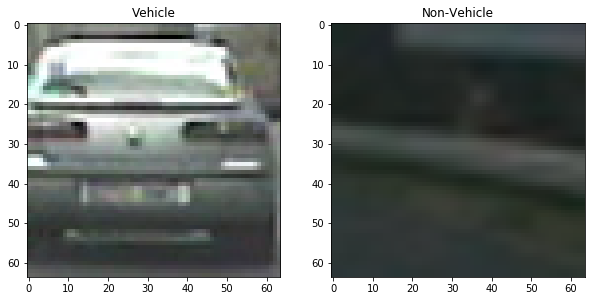

In [4]:
vehicle = vehicles[12]
non_vehicle = non_vehicles[12]

fig, axes = plt.subplots(ncols=2, figsize=(10, 10))
axes[0].imshow(vehicle)
axes[0].set_title('Vehicle')
axes[1].imshow(non_vehicle)
axes[1].set_title('Non-Vehicle')

print('Vehicle train image count: {}'.format(len(vehicles)))
print('Non-vehicle train image count: {}'.format(len(non_vehicles)))

## Feature Extraction

In [5]:
from skimage.feature import hog

In [9]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
        
def extract_features(image, params):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size)

    # Apply color_hist() 
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    
    return np.concatenate((spatial_features, hist_features, hog_features))

## Training SVC model

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [11]:
# Value object to hold all feature extraction parameters.
class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 8 # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2  # HOG cells per block
        self.hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
        # Spatial binning dimensions
        self.size = (16, 16) 
        # Histogram parameters
        self.hist_bins = 32  # Number of histogram bins
        self.hist_range = (0, 256)
# set parameters
params = FeaturesParameters() 

In [14]:
# Feature generation
vehicle_features = [extract_features(img, params) for img in vehicles]
non_vehicle_features = [extract_features(img, params) for img in non_vehicles]
# Stacking and scaling features
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
scaler = StandardScaler().fit(X)
scaled_X = scaler.transform(X)
# Defining labels
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
svc_model = LinearSVC()
svc_model.fit(X_train, y_train)
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc_model.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc_model.score(X_test, y_test), 4))

Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9935


## Showing HOG images from training

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


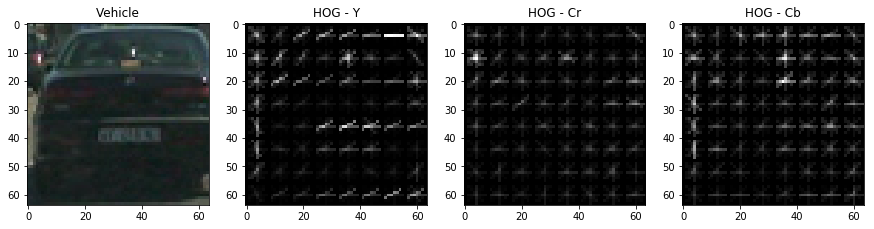

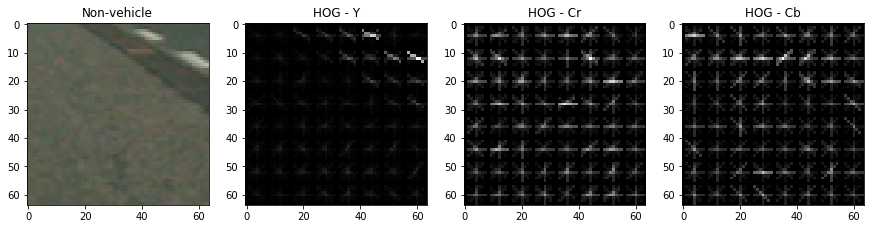

In [16]:
def show_hog(img, title):
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = get_hog_features(img_cspaced[:,:,0], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

show_hog(vehicles[25], 'Vehicle')
show_hog(non_vehicles[32], 'Non-vehicle')

## Sliding Window

In [39]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

## Test Images

In [40]:
test_image_files = glob.glob('./test_images/*.jpg')
test_images = []
for image in test_image_files:
    test_images.append(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB))

In [41]:
# Basic functions provided on Udacity's course to creating windows and drawing boxes on an image.
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
def find_car_windows(img, model, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    #1) Create an empty list to receive positive detection windows
    car_windows = []
    # y_start_stop: Y axis range to find the cars.
    # xy_window: windows size.
    # xy_overlap: windows overlap percent.
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = model.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

test_images_detected = []
for image in test_images:
    car_windows = find_car_windows(image, svc_model, scaler, params)
    test_images_detected.append(draw_boxes(image, car_windows))

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


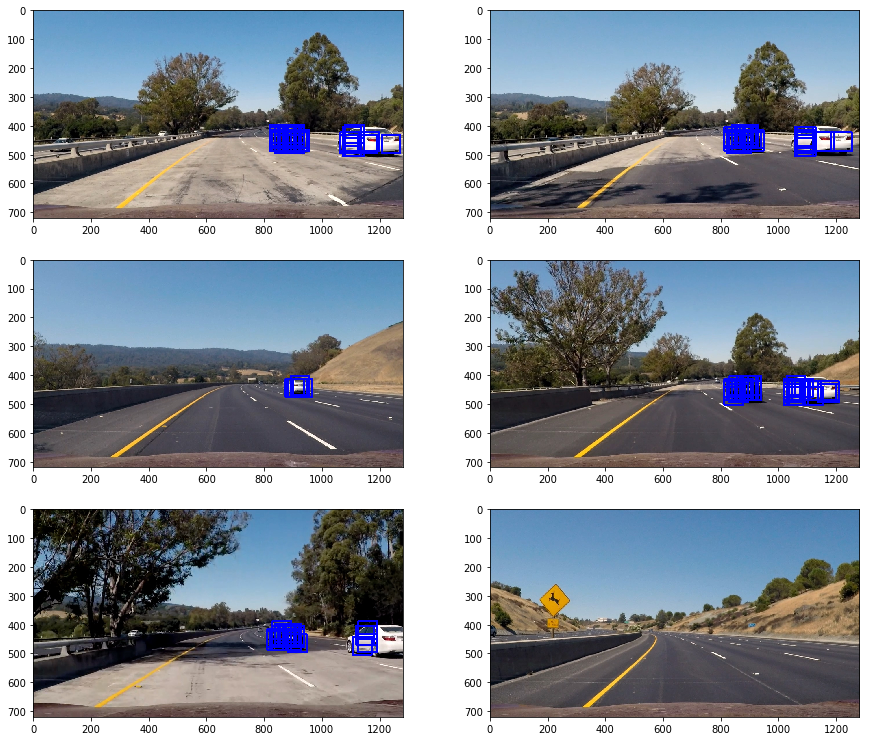

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(15,13))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    image_show = test_images_detected[index]
    ax.imshow(image_show)

## Heatmap and Labels

In [43]:
from scipy.ndimage.measurements import label

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


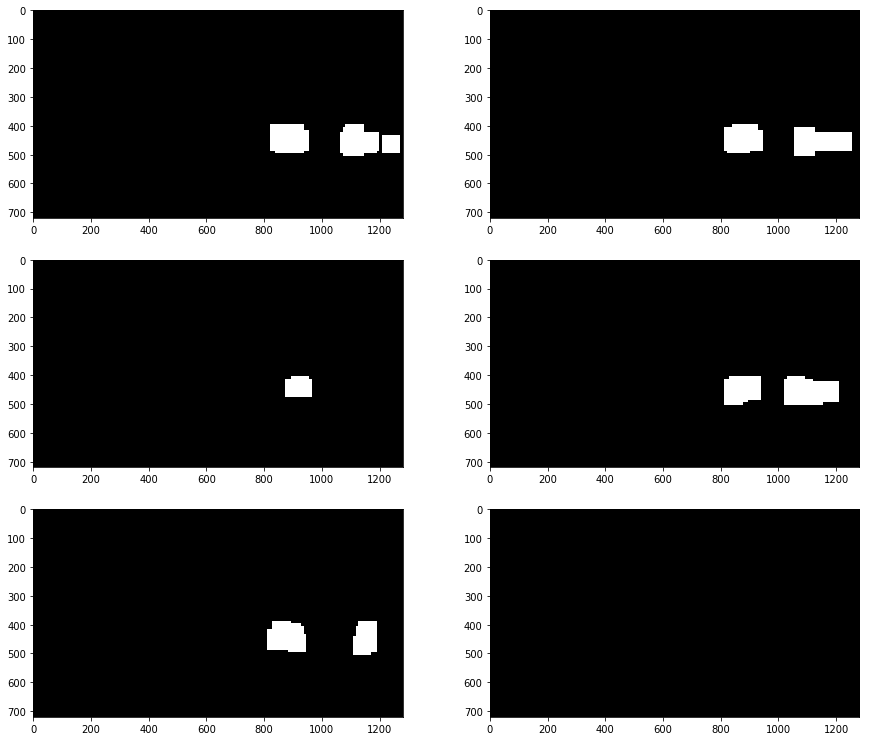

In [44]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

test_images_heatmap = []
for image in test_images:
    car_windows = find_car_windows(image, svc_model, scaler, params)
    heatmap = add_heat(np.zeros(image.shape), car_windows)
    test_images_heatmap.append(heatmap)
# show heatmap
fig, axes = plt.subplots(3, 2, figsize=(15,13))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    image_show = test_images_heatmap[index]
    ax.imshow(image_show)

In [45]:
def draw_labeled_bboxes(img, labels):
    imcopy = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return imcopy

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


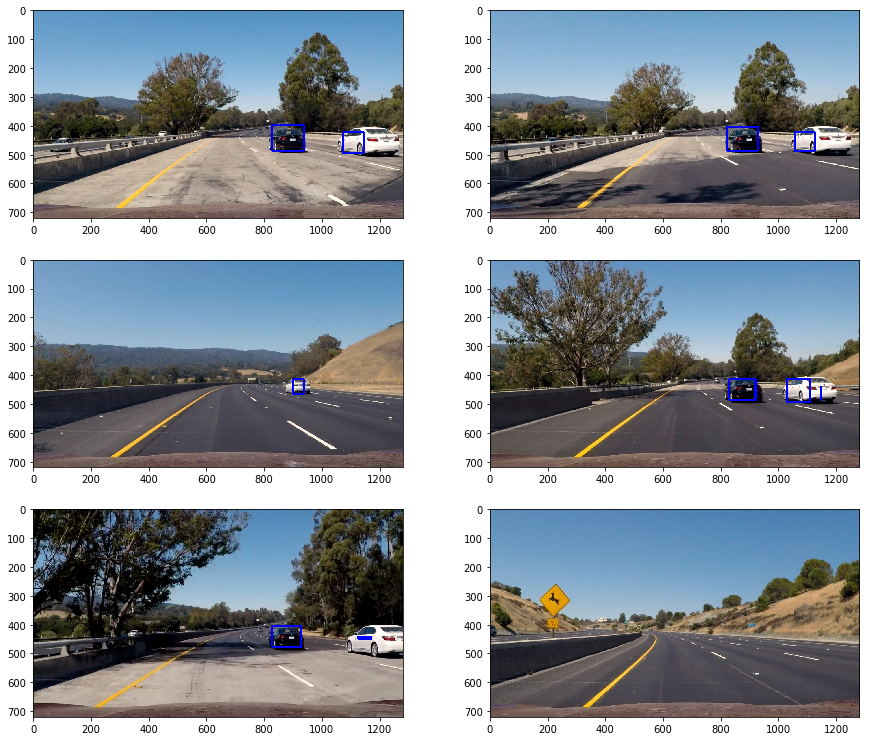

In [46]:
test_images_labels = []
for image in test_images:
    car_windows = find_car_windows(image, svc_model, scaler, params)
    heatmap = add_heat(np.zeros(image.shape), car_windows)
    heatmap = apply_threshold(heatmap, threshold = 4)
    labels = label(heatmap)  
    test_images_labels.append(draw_labeled_bboxes(image, labels))
# show merged images
fig, axes = plt.subplots(3, 2, figsize=(15,13))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    image_show = test_images_labels[index]
    ax.imshow(image_show)

## Improving performance with HOG sub-sampling

In [47]:
def find_car_windows_optimize(img, model, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = model.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


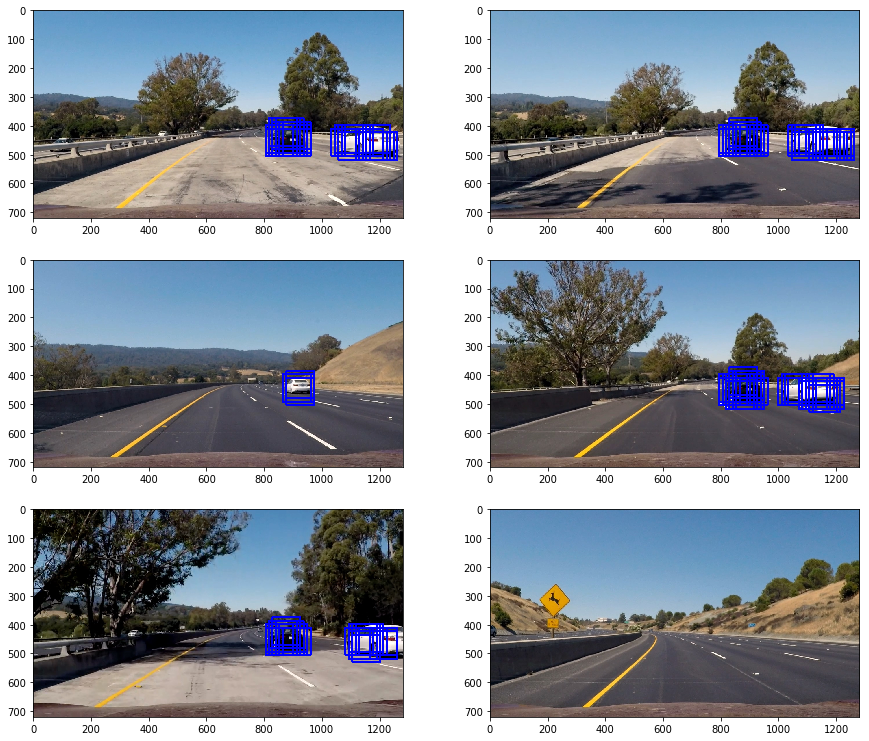

In [48]:
test_images_detected_optimize = []
for image in test_images:
    car_windows = find_car_windows_optimize(image, svc_model, scaler, params)
    test_images_detected_optimize.append(draw_boxes(image, car_windows))
# Show detected images
fig, axes = plt.subplots(3, 2, figsize=(15,13))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    image_show = test_images_detected_optimize[index]
    ax.imshow(image_show)

/home/dongnanzhy/miniconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


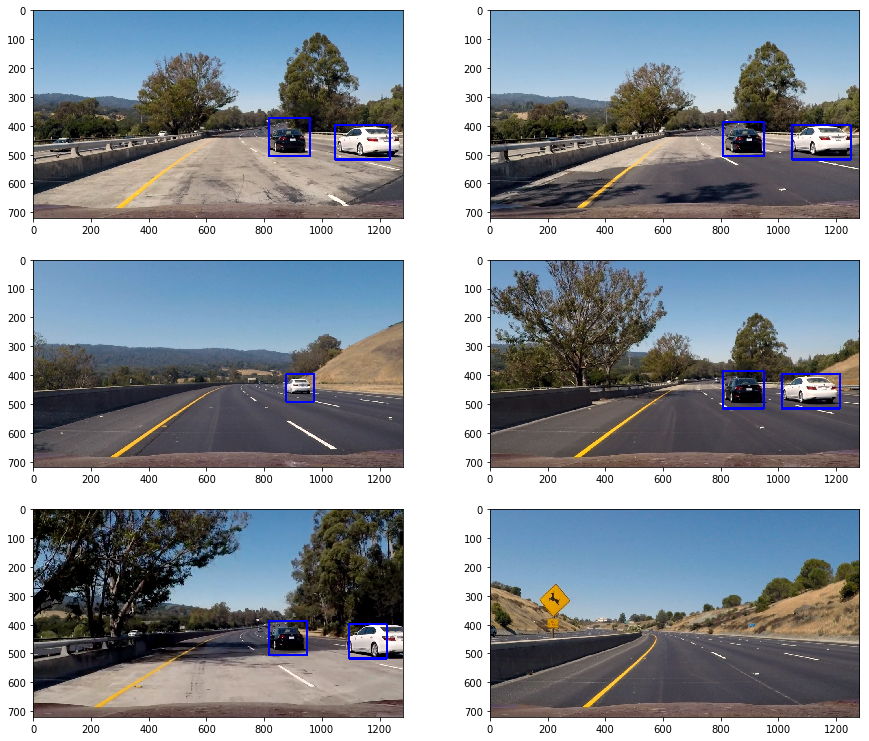

In [51]:
test_images_labels_optimize = []
for image in test_images:
    car_windows = find_car_windows_optimize(image, svc_model, scaler, params)
    heatmap = add_heat(np.zeros(image.shape), car_windows)
    heatmap = apply_threshold(heatmap, threshold = 2)
    labels = label(heatmap)  
    test_images_labels_optimize.append(draw_labeled_bboxes(image, labels))
# show merged images
fig, axes = plt.subplots(3, 2, figsize=(15,13))
indexes = range(6)
for ax, index in zip(axes.flat, indexes):
    image_show = test_images_labels_optimize[index]
    ax.imshow(image_show)

## Video Pipeline

In [52]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=2):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = find_car_windows_optimize(img, svc_model, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(img, labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('project_video.mp4', './output_images/project_video.mp4', threshhold=2)

[MoviePy] >>>> Building video ./output_images/project_video.mp4
[MoviePy] Writing video ./output_images/project_video.mp4


100%|█████████▉| 1260/1261 [19:08<00:00,  1.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 



In [53]:
processVideo('test_video.mp4', './output_images/test_video.mp4', threshhold=2)

[MoviePy] >>>> Building video ./output_images/test_video.mp4
[MoviePy] Writing video ./output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:34<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video.mp4 

